In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras import backend as k
%matplotlib inline
import pickle
from keras.utils import to_categorical
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation, Dropout, BatchNormalization
from keras.layers import LeakyReLU
from keras.optimizers import Adamax
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K




In [ ]:
RESIZE_DIM=32
FIG_WIDTH=20
HEIGHT_PER_ROW=3


In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/dataset/handw_bangla.zip'
output_dir = '/content/unzip'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print("ZIP file extracted successfully.")


ZIP file extracted successfully.


In [ ]:
data_dir=os.path.join('/content/unzip')
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e



paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')





In [ ]:
'''indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.80)
# train data
X_train=X_train_all[indices[:ind]]
y_train=y_train_all[indices[:ind]]'''

def get_key(path):

    key=path.split(sep=os.sep)[-1]
    return key

def get_data(paths_img,path_label=None,resize_dim=None):

    X=[]
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)

        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) # resize image to 28x28

        gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0) #unblur
        img = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
        img = cv2.filter2D(img, -1, kernel)

        X.append(img) # expand image to 28x28x1 and append to the list
        # display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)

    X=np.array(X) # tranform list to numpy array
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) # read labels
        df=df.set_index('filename')
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
        y=to_categorical(y_label,10) # transfrom integer value to categorical variable
        return X, y

def imshow_group(X,y,y_pred=None,n_per_row=10,phase='processed'):

    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,HEIGHT_PER_ROW*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
#
        plt.imshow(img)
        if phase=='processed':
            plt.title(np.argmax(y[i]))
        if phase=='prediction':
            top_n=3
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
            if y is not None:
                plt.text(img_dim/2, -4, 'true label: {}'.format(np.argmax(y[i])),
                         horizontalalignment='center',verticalalignment='center')
        plt.axis('off')
    plt.show()

def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

In [ ]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)


processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [ ]:
X_train_all=np.concatenate((X_train_a,X_train_b,X_train_c,X_train_d,X_train_e),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)
X_train_all.shape, y_train_all.shape





((72045, 32, 32), (72045, 10))

In [ ]:
X_show_all=X_train_all

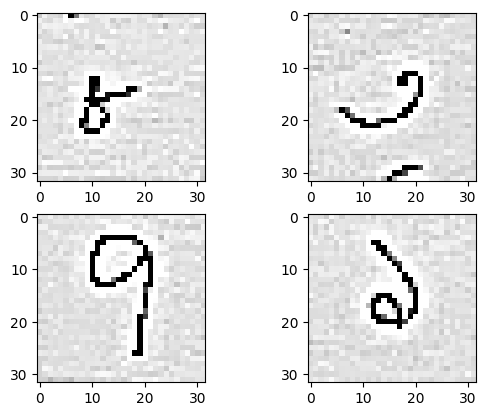

In [ ]:
plt.subplot(221)
plt.imshow(X_train_all[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_all[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_all[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_all[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

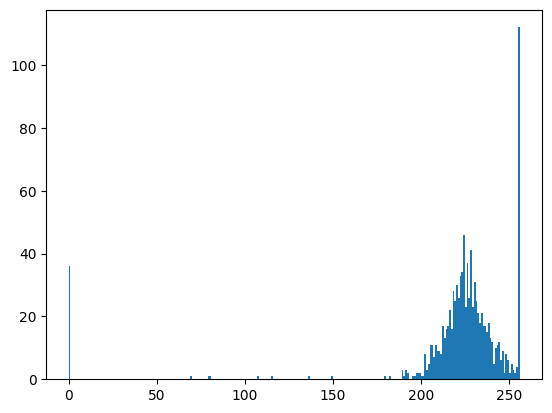

In [ ]:
imgg=X_train_all[1]
hist = cv2.calcHist([imgg],[0],None,[256],[0,256])
plt.hist(imgg.ravel(),256,[0,256])

# show the plot ting graph of an image

plt.show()

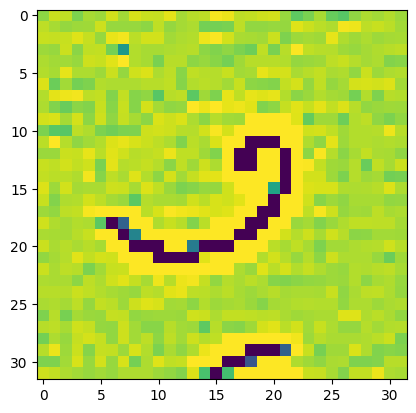

In [ ]:
plt.imshow(X_train_all[1])

In [ ]:
#test data resizing

X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)


processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 495/495
processed 2168/2168
processed 2106/2106


In [ ]:
X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))

In [ ]:
X_tshow_all=X_test_all
X_tshow_all.shape

(17626, 32, 32)

In [ ]:
X_train_all = X_train_all.reshape(X_train_all.shape[0],32, 32,1).astype('float32')
X_test_all = X_test_all.reshape(X_test_all.shape[0],32, 32,1).astype('float32')

In [ ]:
X_train_all.shape

(72045, 32, 32, 1)

In [ ]:
X_train_all = X_train_all/255
X_test_all=X_test_all/255

In [ ]:
indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.80)
# train data
X_train=X_train_all[indices[:ind]]
y_train=y_train_all[indices[:ind]]
# validation data
X_val=X_train_all[indices[-(len(indices)-ind):]]
y_val=y_train_all[indices[-(len(indices)-ind):]]

In [ ]:
def my_model(img_size=32,channels=1):
    model = Sequential()
    input_shape = (img_size,img_size,channels)
    model.add(Conv2D(32, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()

    return model
model=my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        25632     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       36992     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       1

Epoch 1/30
901/901 [==============================] - 32s 18ms/step - loss: 0.9683 - accuracy: 0.6484 - val_loss: 0.2953 - val_accuracy: 0.9223
Epoch 2/30
901/901 [==============================] - 15s 16ms/step - loss: 0.1582 - accuracy: 0.9543 - val_loss: 0.1387 - val_accuracy: 0.9586
Epoch 3/30
901/901 [==============================] - 14s 15ms/step - loss: 0.1030 - accuracy: 0.9702 - val_loss: 1.2897 - val_accuracy: 0.7397
Epoch 4/30
901/901 [==============================] - 14s 16ms/step - loss: 0.0795 - accuracy: 0.9774 - val_loss: 0.0984 - val_accuracy: 0.9743
Epoch 5/30
901/901 [==============================] - 14s 16ms/step - loss: 0.0663 - accuracy: 0.9810 - val_loss: 0.3809 - val_accuracy: 0.9167
Epoch 6/30
901/901 [==============================] - 14s 15ms/step - loss: 0.0592 - accuracy: 0.9834 - val_loss: 0.8226 - val_accuracy: 0.8477
Epoch 7/30
901/901 [==============================] - 14s 15ms/step - loss: 0.0517 - accuracy: 0.9857 - val_loss: 0.3012 - val_accuracy:

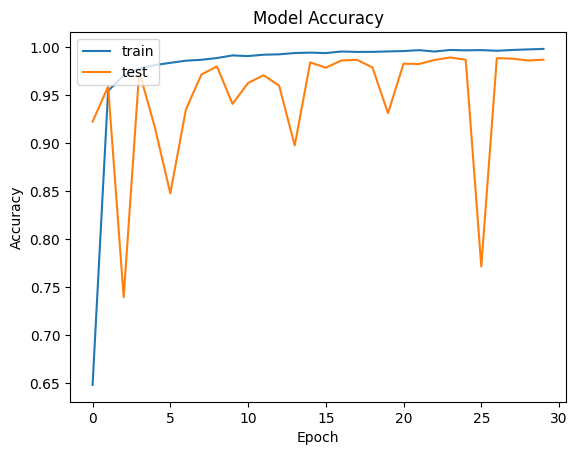

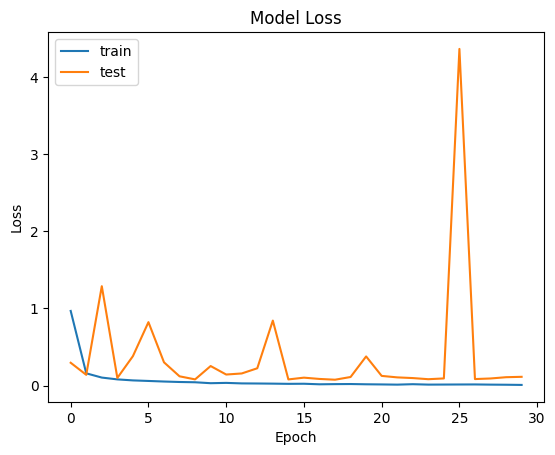

In [ ]:
path_model='model_filter.h5'
K.clear_session()
model = my_model()
K.set_value(model.optimizer.lr, 1e-3)

# fit the model
h = model.fit(x=X_train,
              y=y_train,
              batch_size=64,
              epochs=30,
              verbose=1,
              validation_data=(X_val, y_val),
              shuffle=True,
              callbacks=[
                  ModelCheckpoint(filepath=path_model),
              ])



plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions_prob=model.predict(X_test_all) # get predictions for all the test data

551/551 [==============================] - 2s 3ms/step


In [ ]:
n_sample=200
np.random.seed(42)
ind=np.random.randint(0,len(X_test_all), size=n_sample)

In [ ]:
def imshow_group(X, y, y_pred=None, n_per_row=10, phase='processed'):


    n_sample = len(X)
    img_dim = X.shape[1]
    j = int(np.ceil(n_sample / n_per_row))  # Convert number of rows to integer
    fig = plt.figure(figsize=(FIG_WIDTH, HEIGHT_PER_ROW * j))
    for i, img in enumerate(X):
        plt.subplot(j, n_per_row, i + 1)
        plt.imshow(img)
        if phase == 'processed':
            plt.title(np.argmax(y[i]))
        if phase == 'prediction':
            top_n = 3  # top 3 predictions with highest probabilities
            ind_sorted = np.argsort(y_pred[i])[::-1]
            h = img_dim + 4
            for k in range(top_n):
                string = 'pred: {} ({:.0f}%)\n'.format(ind_sorted[k], y_pred[i, ind_sorted[k]] * 100)
                plt.text(img_dim / 2, h, string, horizontalalignment='center', verticalalignment='center')
                h += 4
            if y is not None:
                plt.text(img_dim / 2, -4, 'true label: {}'.format(np.argmax(y[i])),
                         horizontalalignment='center', verticalalignment='center')
        plt.axis('off')
    plt.show()


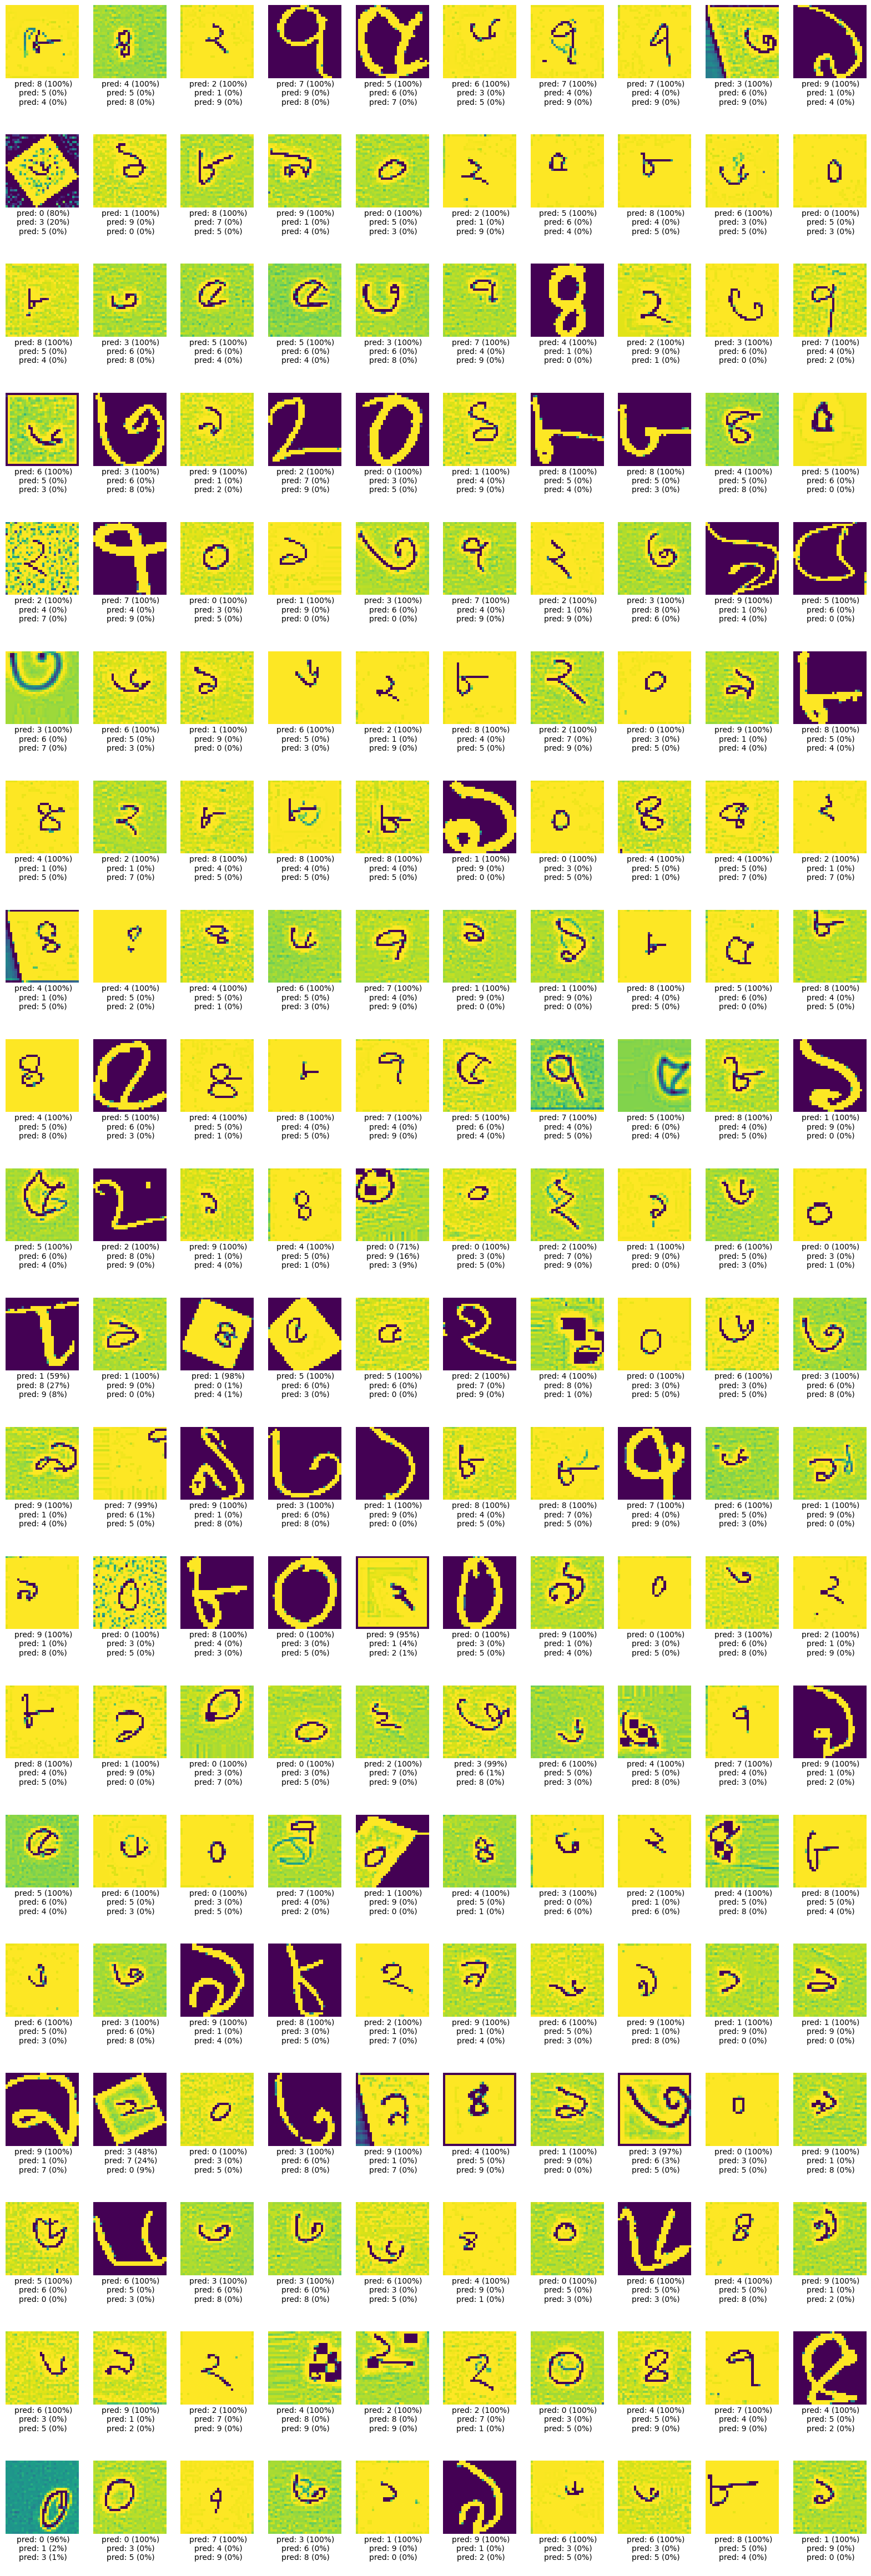

In [ ]:
imshow_group(X=X_tshow_all[ind],y=None,y_pred=predictions_prob[ind], phase='prediction')

In [ ]:
labels=[np.argmax(pred) for pred in predictions_prob]

In [ ]:
keys=[get_key(path) for path in paths_test_all ]

In [ ]:
create_submission(predictions=labels,keys=keys,path='cnnsubmission32_final.csv')

In [ ]:
prediction = pd.read_csv('cnnsubmission32_final.csv')
prediction.head(100)

,key,label
0,a00061.png,8
1,a02801.png,5
2,a00291.png,7
3,a02133.png,5
4,a01246.png,0
...,...,...
95,a00049.png,6
96,a02737.png,6
97,a00236.png,5
98,a02665.png,8


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
y_true = np.array([0, 1, 0, 1, 1, 2, 0, 1, 2, 2])
y_pred = np.array([0, 1, 0, 1, 0, 2, 1, 1, 2, 0])


In [ ]:
cm = confusion_matrix(y_true, y_pred)


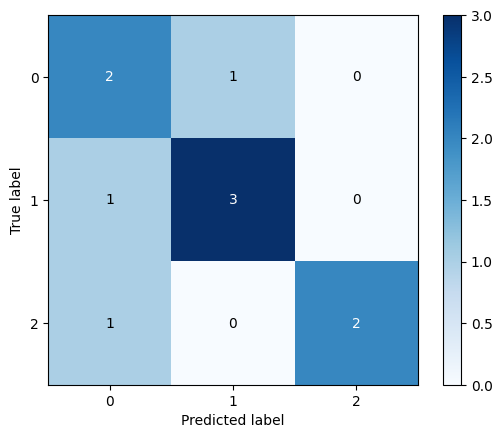

In [ ]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
classes = np.unique(y_true)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()
